# Model Evaluation

## Seth Adams

### Overview

Continuing from the feature engineering section, all models in this notebook used a merged model which concatentated 16 computed features from image segmentation with a larger model from keras.applications. These are length_x, length_y, area, and haralick textures. I left out some feature calculations from mahotas because it is reasonable for a convolutional neural network to build more robust features. If you would like to add additional features then modify the segmentation class. I simply commented them out. I built all features in extracted_features.csv, and saw that image size was log distributed. In order to create a normal/ multimodal distribution I took the natural log of x_length, y_length, and area.

It's actually quite hard to tell if these features helped the model, but they did not lower accuracy. These features will probably only help as the data size gets larger, but I ran comparison models and didn't see much of a difference. I started to get reasonable results when I balanced classes using sampling with replacement from the population images. This approach is not ideal since some images from training will appear in the validation set even after soft augmentation of the images. I have to work with the data given, but I believe the user will now have a more robust data pipeline to work with as the dataset size increases.

**How to run for new image files.**

There are two files that needs to run before modeling. There are build_csv.py and build_extracted_features.py. 

build_csv.py - creates a csv to store image names with their corresponding labels. If attempting multiclassification, change mod_labels dictionary to include multiple classes. This also builds a class_map.pickle file, which simply makes retrieving these class mappings easier in the future. mod_labels will not reflect in class_map. Only the csv file generated.

build_extracted_features.py - In my opinion if the user only wants size features and haralick textures, features only need to be computed for the source images. Multiple augmentations of that image can use the same extracted features. Images are segmented and padded to the target size for whatever neural network you want to run. Computed features are storing a dictionary where image name maps to extracted features. This allows for constant time lookup when data gets batched. This dictionary is stored as features.pickle. Extracted_features.csv is stored simply to let the user inspect computed features. A MinMaxScaler object is fitted to scale features from 0 to 1. Idealy, this normalizer.pickle is created on the training set and then used whenever data is tested. Normalization is nessesary as preprocessing for the second input to the neural network. This file also builds padded images into whatever directory they want.

Now you are ready to model using model_generator.py

**Model generator** allows for the user to batch data and apply random augmentations with every pass of the dataset. This means that each epoch the algorithm sees "new" data. This is usful to prevent overfitting on the validation set. I generally augmented training, and kept validation data the same. The user should take note of the __data_generation method in data_generator.py. This method builds each batch of data by taking paths to each image with their corresponding labels at the indices of the input lists. The user should only need to change this method if they want to modify anything. It typically took me 1 to 2 hours training InceptionV3 using a GTX 1070.

**Model cached** can allow the user to train the model quickly by storing images into memory before the GPU trains the neural network. This approach is good to see quick results, but does not allow for dynamic augmentation of the training set. I don't recommend using model_cached.py since precomputing paddd images and features for model_generator is more robust, but I will leave it in the repo.

### Augmentation demo

Image augmentation were performed using the imgaug library. https://imgaug.readthedocs.io/en/latest/

Image augmentation is quite common even when the user has a large data size. I used fairly light augmentation because certain affine transformations such as cropping or translating can remove the plankton from the image. This can cause segmentation errors and break everything.

The following augmentations are applied in a random order:

 - Horizontal flip (50%)
 - Gaussian Blur between 0 and 0.2 sigma (50%)
 - Multiply between 0.6 and 1.4 (brighter and darker)
 - Affine transformations
     * Scale x and y between 0.8 and 1.2
     * Rotate between -90 and 90
     * Shear between -8 and 8

In [1]:
from augment import seq
import os
import matplotlib.pyplot as plt
from segmentation import Segmentation

def plot_images(images):
    fig, axes = plt.subplots(nrows=4, ncols=5, sharex=False,
                             sharey=True, figsize=(16,10))
    fig.suptitle('Augmented Plankton (original top left)', size=20)
    i = 0
    for x in range(4):
        for y in range(5):
            axes[x,y].imshow(images[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

data_path = os.path.join(os.getcwd(), 'data')
class_path = os.path.join(data_path, 'Calanus')
im_path = os.path.join(class_path, 'SPC-PWSSC-0-000901-093-2938-1440-404-408.png')

images = []
plankton = Segmentation(im_path)
plankton.segment()
padded = plankton.get_padded()
images.append(padded)
for _ in range(19):
    aug = seq.augment_image(padded)
    images.append(aug)
plot_images(images)
plt.show()

<Figure size 1600x1000 with 20 Axes>

### Model Architecture

I had the most sucess with InceptionV3. I did not try ResNet50 or VGG16. I generally advise against using VGG16 since it uses so much memory to keep track of model weights. DenseNet and NASNet seemed to take longer to train and struggled to get good validation results. Xception was ok, but validation seemed poor. This could all be due to small data size, so try some things out for yourself.

I used an image size of (75, 75, 3). This is the smallest input shape for inceptionV3. Because plankton is so small, I don't see much advantage to using a larger image size. I found larger images to just slow down training time.

The model is quite start forward. Lets take a look at the model summary. I stored entire model files, but these is an option to store h5 files for weights and json or yaml files for the architecture.

In [2]:
from keras.models import load_model

model = load_model('./models/inception_v3.model')
model.summary()

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 1, 1, 2048)   21802784    input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 2048)         0           inception_v3[1][0]               
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
dense_1 (D

![inception_arch](ipynb_files/inception_arch.png)

If you look at the inception model, you see that final part at the end. I connected to the model using a global average pooling layer. This can be replaced with a global max pooling or flatten layer. I used one dropout layer with 0.5 strength, but more dropout is an option between FC layers. A dense layer with 256 neurons is used into a concatenation layer. Now that I think about it I should have used 112 neurons here to merge with the extracted features for 128, but it's ok. So at this point a second input concatenated with the extracted features from inception. And go through another FC layer with 64 neurons. The final layer have n_classes neurons with softmax activation for classification.

### Model 1 - InceptionV3 merged with extracted features. Class weight using all data. No augmentations.

All models used a 5% validation split. Calculation of class weights via the sklearn method (compute_class_weight) was attempted. This resulted in a model that started at a very high accuracy probably due to the large amounts of data in the blob and unknown classes. The model clearly overfits the data and struggles to classify unseen data. I believe any poor validation evaluation was due to class imbalance.

![InceptionV3_class_weight](ipynb_files/class_weight_balanced.png)

### Model 2 - InceptionV3 merged with extracted features. Balanced classes. Train augmented. Val not augmented.

3k images per class. Images are sampled with replacement from population set in order to create class balance. Images were augmented randomly on the training set. I probably could have trained longer, it's more important to see what the confusion matrix looks like.

![InceptionV3_all_classes](ipynb_files/inceptionV3_3k.png)

In order for this notebook to display results. Model results are created and stored using the evaluate_model.py file. I'm simply using the results to plot the confusion matrix.

In [3]:
import pandas as pd

df = pd.read_csv('./model_results/inception_v3.csv')
df.sample(10)

,y_true,y_pred
8127,35,35
6162,17,17
3306,4,4
8334,36,3
10199,36,9
7261,23,23
2288,3,3
7138,23,23
10476,36,8
9185,36,15


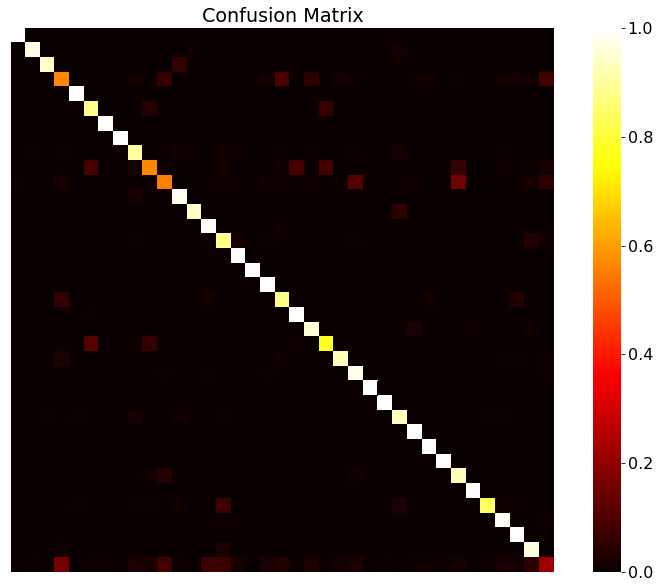

Accuracy: 0.6029
F1 Score: 0.5925
These classes performed under the 0.8 accuracy threshold.

Blob performed with an accuracy of 0.565
Cope_lg performed with an accuracy of 0.568
Cope_sm performed with an accuracy of 0.552
Neocalanus performed with an accuracy of 0.78
Unknown performed with an accuracy of 0.221


In [4]:
import seaborn as sns
import matplotlib as mpl
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import pickle

with open('class_map.pickle', 'rb') as handle:
    class_map = pickle.load(handle)

mpl.rcParams['font.size'] = 16
mpl.rcParams['figure.figsize'] = (14,10)
mpl.rcParams['axes.labelsize'] = 16

def plot_conf_mat(df):
    acc = str(round(accuracy_score(df.y_true, df.y_pred), 4))
    f1 = str(round(f1_score(df.y_true, df.y_pred, average='weighted'), 4))
    conf_mat = confusion_matrix(df.y_true, df.y_pred)
    conf_mat = conf_mat.astype(dtype=np.float16)
    for row in range(conf_mat.shape[0]):
        conf_mat[row,:] = conf_mat[row,:] / sum(conf_mat[row,:])


    plt.title('Confusion Matrix')
    sns.heatmap(conf_mat, cmap='hot', square=True, xticklabels=False, yticklabels=False)
    plt.show()

    print('Accuracy: {}'.format(acc))
    print('F1 Score: {}'.format(f1))
    
    return conf_mat

            
df = pd.read_csv('./model_results/inception_v3.csv')
conf_mat = plot_conf_mat(df)

threshold = 0.8
print('These classes performed under the {} accuracy threshold.\n'.format(threshold))
for i in range(conf_mat.shape[0]):
    if conf_mat[i,i] < threshold:
        print('{} performed with an accuracy of {}'.format(class_map[i], str(round(conf_mat[i,i], 3))))

Blob, cope_lg, cope_sm, and unknown all performed poorly here. I find it odd that the two copes don't have more confusion with each other. It's more likely that cope gets distaken as a different class. Other species of cope? There is a common theme in this data where classes with larger data size have low accuracy. It seems that augmenting to create class balance can only help so much. I think the convolutional net could learn more if it just had more variance in it's features for each class.

In [5]:
def show_misclassifications(conf_mat, threshold=0.1):
    for i in range(conf_mat.shape[0]):
        conf_mat[i,i] = 0.0
    x, y = np.where(conf_mat > threshold)
    for x, y in zip(x,y):
        print('{0:2} was misclassified as {1:10}'.format(class_map[x], class_map[y]))

show_misclassifications(conf_mat)

Blob was misclassified as Limacina  
Cope_sm was misclassified as Oithona   
Cope_sm was misclassified as Pseudocalanus
Neocalanus was misclassified as Calanus   
Unknown was misclassified as Blob      


So looking at some classes with a misclassification of over 0.1 for another specific class we can see some conflicts. Blob and limacina is understandable since if I just look at limacina some of these look like blobs to me. It's also interesting that cope_sm is confused with these other classes. I did ask Rob and he said cope_lg and cope_sm are just classes meant to catch all copepods. I think multiclassification might be able to resolve this issue, but we'll take a look at that later. Unknown seems to be the largest issue probably since it appears to be a random class meant to catch everything else. I decided to try dropping cope_sm, cope_lg, poorlysegmented, and unknown since these classes seemed very vague and unspecific.

### Model 3 - InceptionV3 merged with features. Dropped 4 classes.

The dropped 4 model certainly removed some ambiguity from the model. Again I feel like this model was undertrained, but it appears to have reached higher accuracy probably since unknown is gone.

![InceptionV3_dropped_4](ipynb_files/inceptionV3_dropped_4.png)

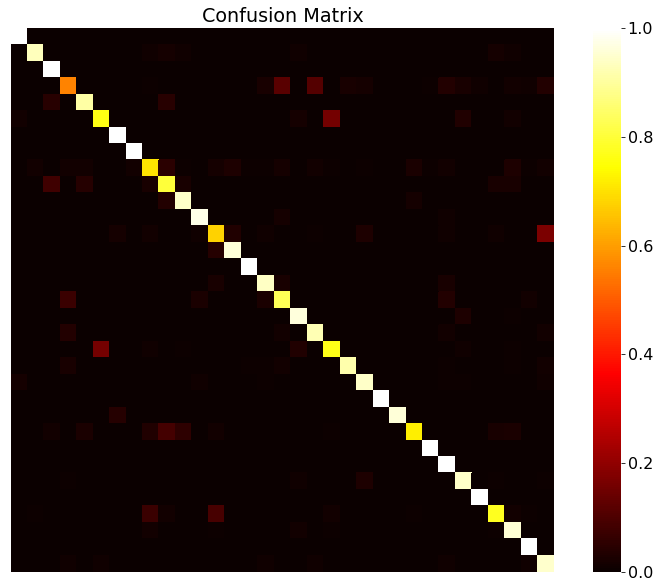

Accuracy: 0.7102
F1 Score: 0.7433
These classes performed under the 0.8 accuracy threshold.

Blob performed with an accuracy of 0.561
Calanus performed with an accuracy of 0.762
Cnidaria performed with an accuracy of 0.706
Filament performed with an accuracy of 0.677
Neocalanus performed with an accuracy of 0.768
Pleurobrachia performed with an accuracy of 0.72
Siphonophora performed with an accuracy of 0.774


Blob was misclassified as Limacina  
Blob was misclassified as Nauplius  
Calanus was misclassified as Neocalanus
Filament was misclassified as Spiral    
Neocalanus was misclassified as Calanus   


In [6]:
df = pd.read_csv('./model_results/inception_v3_drop_4.csv')

with open('dropped_4_class_map.pickle', 'rb') as handle:
    class_map = pickle.load(handle)

conf_mat = plot_conf_mat(df)

threshold = 0.8
print('These classes performed under the {} accuracy threshold.\n'.format(threshold))
for i in range(conf_mat.shape[0]):
    if conf_mat[i,i] < threshold:
        print('{} performed with an accuracy of {}'.format(class_map[i], str(round(conf_mat[i,i], 3))))

print('\n')
show_misclassifications(conf_mat)

This model turned out quite good even though the confusion matrix has less white and a little more yellow for some classes. I think some of these classes with 0.8 accuracy could go up if I just trained longer. The most notable metric is an F1 score of 0.74, which is one of the best for all these models I've been running. F1 score is generally more important than accuracy since it gives an idea of how well a model can generalize on data. So it seems this model improved mainly because unknown was left out. I think the high amount of variance in the features created from unknown actually helped with other classes, but hurt overall model performance simply from class imbalance. So again I think there are misclassifications with different copepods. Let's see how a multiclassification model does.

### Model 4 - InceptionV3 merged with features. Multiclassification to attempt to resolve copepods.

The only difference between this model and previously inceptionV3 models is the use of binary_crossentropy in the loss function and the use of sigmoid activations instead of softmax. I also reduced data size per epoch for the generator, so you can see many more epochs for these accuracy and loss curves. Also you can see a curve in the middle for F1 score. The accuracy is looking over hot encoded vectors so accuracy is not relevant here.

![InceptionV3_multi](ipynb_files/inception_multi.png)

In [7]:
df = pd.read_csv('plankton_multi.csv')
df.sample(20)

,im_name,label
7692,SPC-PWSSC-1466458362-000588-074-1012-2068-132-...,[27 9]
5026,SPC-PWSSC-1470907973-000480-051-2950-1004-316-...,9
1815,SPC-PWSSC-1460129224-000502-055-1176-1788-52-6...,3
5586,SPC-PWSSC-1459783720-000877-071-2164-2250-60-1...,13
5624,SPC-PWSSC-1459956459-000639-069-1684-1838-204-...,13
8260,SPC-PWSSC-1467365586-000618-364-1230-38-48-96.png,32
2695,SPC-PWSSC-1460718229-000268-009-1776-2464-72-7...,3
3623,SPC-PWSSC-1467106295-000311-031-2996-2232-344-...,[5 9]
1040,SPC-PWSSC-1459870100-000804-151-478-1456-40-44...,3
4314,SPC-PWSSC-1463570196-000168-028-3832-696-156-1...,9


Hopefully this random sampling shows some multilabels in the dataframe. I added the classification where acartia, calanus, metridia, neocalanus, oithona, and pseudocalanus all belong to the cope class. I also removed poorlysegmented and unknown. I merged filament and filaments. I merged cope_sm and cope_lg into cope.

Unfortunately, most confusion matrices don't support multiclassification, but I did make a t-SNE graph of the decomposed output to try and get a good visualization. I do like this model had an F1 score of 0.8. It seems to still get blob mixed up with other classes, but this might be resolved with larger data size. 

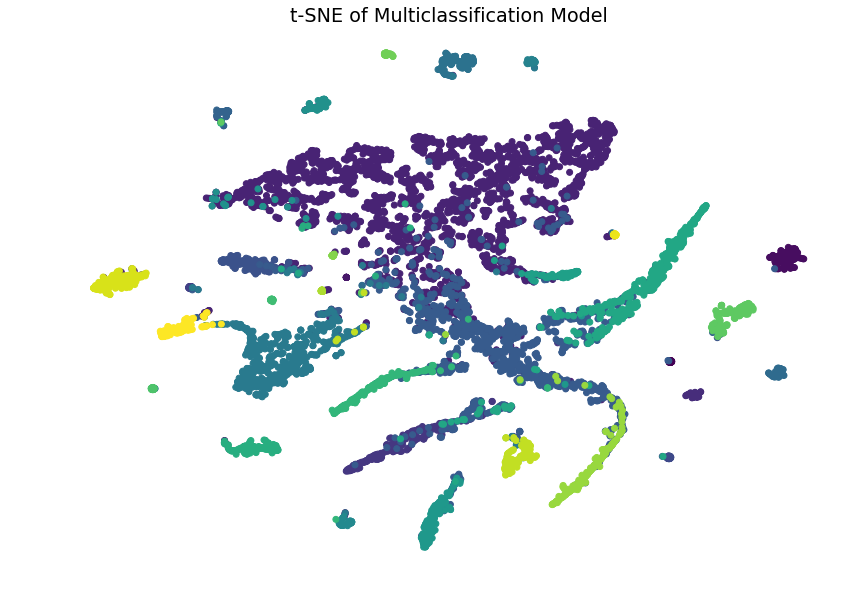

In [8]:
df_tsne = pd.read_csv('./model_results/multi_tsne.csv')
X = df_tsne.values
plt.title('t-SNE of Multiclassification Model')
plt.scatter(X[:,0], X[:,1], c=X[:,-1])
plt.axis('off')
plt.show()

This model isn't perfect. In fact blob still had some weird interactions with other classes. (run evaluate_multi.py to build multi_prob.csv) If you compare this plot to the ones made in feature engineering, you see a drastic improvement. It is hard to show the colormap for 33 different classes, but you can see some hybrid groupings of data where some overlap is seen. It's impossible to tell if this is misclassification or not, but it's an interesting plot none the less. This model was similar to the others in that blob still misclassified as other classes randomly.

### Conclusion

I found InceptionV3 to be the best model for generalizing to a validation set. I used augmentations to try and resolve class imbalance, which worked for training, but somewhat failed when running on the original unbalanced data. I think the main result of this work was building a data pipeline that could have newly collected data ready to be modeled in a few hours.

**Recommendations**:

 - Increase the data size of the lagging classes as much a possible.
 - Consider removing blob and unknown. (any ambiguous classes)
 - Try setting up multi classification yourself. The output of each sigmoid in the final layer will give you a class probability, so if the model is not "confident" enough in it's estimation it's worth discarding the segmentation all together. This could be a way around discarding blob and unknown, while still getting automated results on a live system.
 
 - Take a look into finding ideal thresholds for the multiclassification labels. There is a good example at the end of this notebook on kaggle: https://www.kaggle.com/rejpalcz/cnn-128x128x4-keras-from-scratch-lb-0-328/notebook You can optimize thresholding to maximize F1 score on a cross validated set.
 
Overall, I think these results were fairly promising given how imbalanced the classes were. Comparing to what you had before, I think you have a good data pipeline to make better models as your dataset grows. More data will almost always help deep learning models.